<a href="https://colab.research.google.com/github/l8518/geot-faas/blob/main/data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies

In [1]:
import datetime
import os
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from notebook_shared import utils

from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import Series

import seaborn as sns
sns.set()
matplotlib.style.use('seaborn-colorblind')

INPUT_FILE = "dataset"
FSIZE = "full"
df = pd.read_parquet(utils.get_dataset_path(INPUT_FILE, FSIZE))

#   Data Analysis

In [2]:
dataset = df

In [3]:
coefficient_of_variation = lambda x: np.std(x, ddof=1) / np.mean(x) 

## Measurement Errors (TODO)

In [4]:
measure_target = {'AWS': 10 , 'AZURE': 9 , 'GCP': 10}

In [5]:
measurement_df = dataset.groupby(['driver_invocation', 'provider'])['workload_invocation'].nunique().unstack('provider')

<AxesSubplot:>

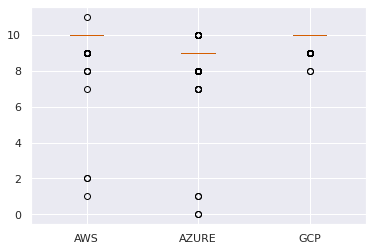

In [6]:
measurement_df.boxplot()

In [7]:
measurement_df[measurement_df['AWS'] > 10]

provider,AWS,AZURE,GCP
driver_invocation,,,
2021-08-04 20:30:04.065,11,9,10


In [8]:
dataset['driver_invocation']

0          2021-08-01 13:30:03.035
1          2021-08-01 13:30:03.035
2          2021-08-01 13:30:03.035
3          2021-08-01 13:30:03.035
4          2021-08-01 13:30:03.035
                     ...          
49935595   2021-09-30 23:30:03.438
49935596   2021-09-30 23:30:03.438
49935597   2021-09-30 23:30:03.438
49935598   2021-09-30 23:30:03.438
49935599   2021-09-30 23:30:03.438
Name: driver_invocation, Length: 49935600, dtype: datetime64[ns]

## Regional Provider Differences

In [9]:
# Common Stuff
provider_region_mapping = {}
provider_region_mg_df = dataset.groupby( ['provider', 'region'], observed=True)['measure group'].unique().reset_index()
provider_region_mg_df
for index, row in provider_region_mg_df.iterrows():
  for measure_group in row['measure group']:
    region = row['region']
    provider = row['provider']
    measure_group = row['measure group'][0]
    provider_region_mapping[f"({provider}, {region})"] = {'region': region, 'measure group': measure_group, 'provider': provider}
    provider_region_mapping[f"({provider}, {region}, {measure_group})"] = {'region': region, 'measure group': measure_group, 'provider': provider}

### Container Ids

In [10]:
uuid_unique_count_df = dataset.groupby(['measure group', 'provider', 'region', 'driver_invocation'], observed=True)['uuid'].nunique().reset_index(name='Unique Container Id')

In [11]:
uuid_unique_count_grouped = dataset.groupby(['measure group', 'provider', 'region', 'driver_invocation'], observed=True)['uuid'].nunique().reset_index(name='Unique Container Id')

In [12]:
uuid_mean_unique_count_df = uuid_unique_count_df.groupby(['measure group', 'provider', 'region'], observed=True)['Unique Container Id'].mean().reset_index(name='Mean Unique Container Id').set_index(['provider', 'region'])
uuid_cv_unique_count_df = uuid_unique_count_df.groupby(['measure group', 'provider', 'region'], observed=True)['Unique Container Id'].apply(coefficient_of_variation).reset_index(name='CV Unique Container Id').set_index(['provider', 'region'])

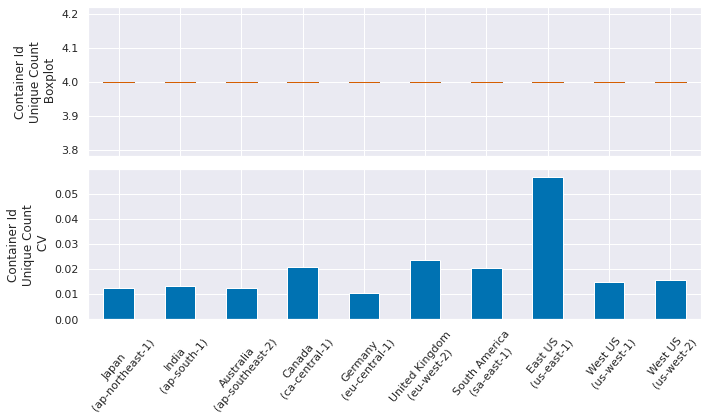

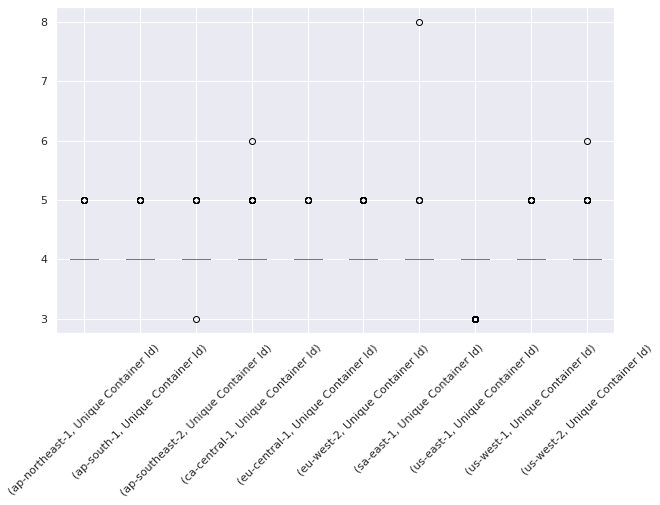

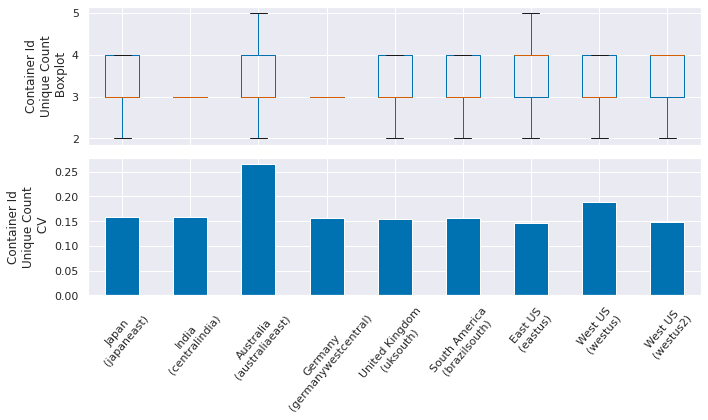

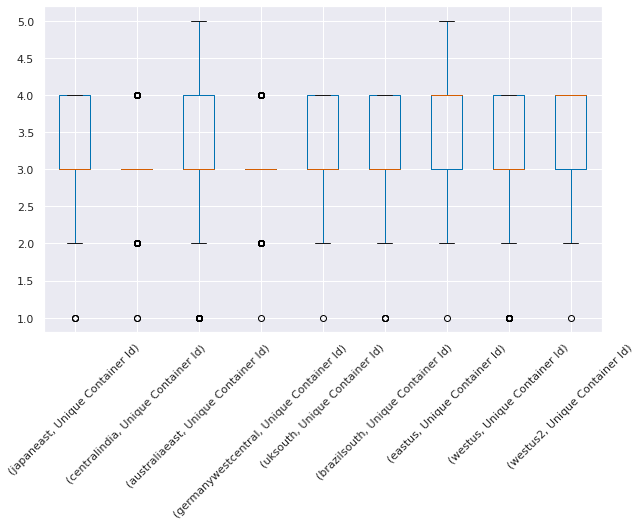

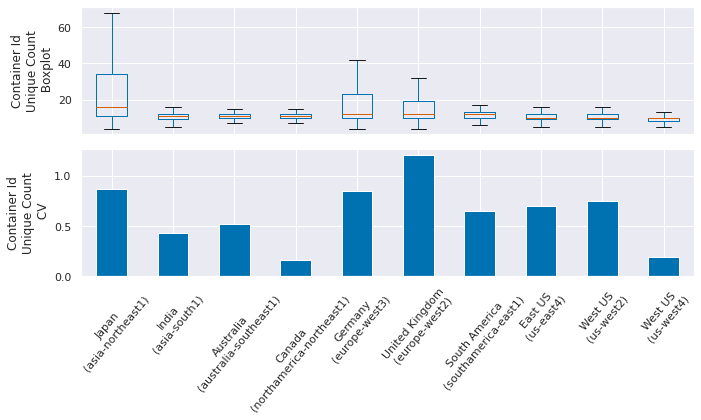

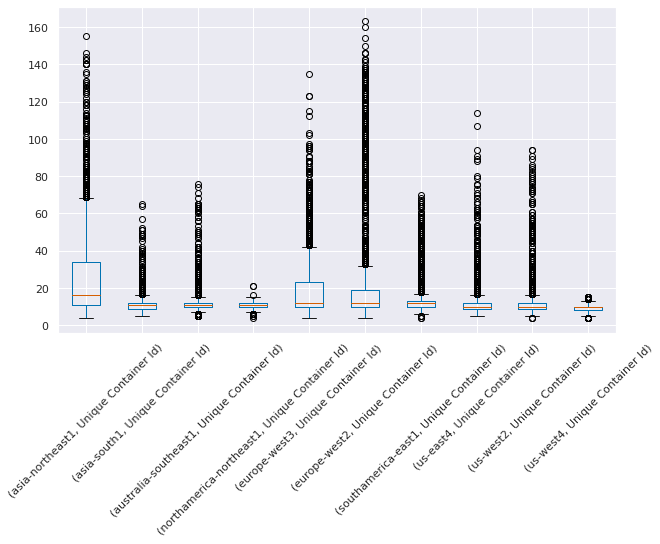

In [13]:
uuid_mean_unique_count_df.sort_values(by=['measure group', 'provider', 'region'])
uuid_cv_unique_count_df.sort_values(by=['measure group', 'provider', 'region'])

for provider in uuid_cv_unique_count_df.index.get_level_values('provider').unique():
    fig, axes = plt.subplots(figsize=(10,6), nrows=2, frameon=False)

    # fig.add_subplot(axsub)
    uuid_unique_count_grouped[uuid_unique_count_grouped['provider'] == provider].groupby(['region'], observed=True).boxplot(subplots=False, ax=axes[0], showfliers=False)
    uuid_cv_unique_count_df[uuid_cv_unique_count_df.index.isin([provider], level='provider')].plot(kind='bar', ax=axes[1])

    axes[0].set_ylabel('Container Id\nUnique Count\n Boxplot')
    labels = []
    for tick in axes[0].get_xticklabels():
        labels.append('')
    
    axes[0].set_xticklabels(labels)

    for tick in axes[1].get_xticklabels():
        tick.set_rotation(50)

    # Set Region Names
    labels = []
    for tick in axes[1].get_xticklabels():
        mapping = provider_region_mapping[tick.get_text()]
        region = mapping['region']
        measure_group = mapping['measure group']
        labels.append(f"{measure_group}\n({region})")

    axes[1].get_legend().remove()
    axes[1].set_ylabel('Container Id\nUnique Count\n CV')
    axes[1].set_xticklabels(labels)
    axes[1].set_xlabel('')

    fig.tight_layout()

    utils.plot( ['data_analysis', f'provider_region_container_ids_{provider}'])

    # Generate a control figure - because I cannot fore the matching
    fig, axes = plt.subplots(figsize=(10,6))
    uuid_unique_count_grouped[uuid_unique_count_grouped['provider'] == provider].groupby(['region'], observed=True).boxplot(subplots=False, ax=axes, rot=45)
    utils.plot( ['data_analysis', f'provider_region_container_ids_{provider}_box'])

## Regional Differences - TODO: Integrate other stuff

In [14]:
cov_regional_df = dataset.groupby( ['measure group', 'provider', 'region'], observed=True)['runtime'].apply(coefficient_of_variation).reset_index(name='Runtime CV').set_index(['provider', 'region', 'measure group'])
cov_regional_df = cov_regional_df.sort_values(by=['measure group', 'provider', 'region'])

# Other Stuff (Experimental)

In [15]:
provider_regions_df = dataset[['provider', 'region']].value_counts().reset_index(name='count')

In [16]:
def plot_mean_col(dataset, provider, region, col):
    provider_df = dataset[dataset['provider'] == provider]
    provider_region_df = provider_df[provider_df['region'] == region]
    mean_latency_df = provider_region_df.groupby(['driver_invocation'])[col].mean()
    
    fig, ax = plt.subplots(figsize=(220,6))
    mean_latency_df.plot(title=f'{provider} {region} mean {col}', style='.-')

    hours = mdates.MinuteLocator(byminute=[0,30]) #or use interval

    hours.MAXTICKS = 3392

    h_fmt = mdates.DateFormatter('%a %H')


    ax.xaxis.set_major_locator(hours)
    ax.xaxis.set_major_formatter(h_fmt)

    fig.autofmt_xdate()

    plt.xticks(rotation=90)
    utils.plot( ['data_analysis', f'plot_mean_col_long_{provider}_{region}_{col}'])

In [17]:
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
import multiprocessing

def plot(indexrowpair):
    index = indexrowpair[0]
    row = indexrowpair[1]
    provider = row['provider']
    region =  row['region']
    df = dataset[['provider', 'region', 'latency', 'runtime', 'driver_invocation']] #.copy()
    plot_mean_col(df, provider, region, 'latency')
    plot_mean_col(df, provider, region, 'runtime')

In [18]:
unique_cpu_models = dataset.groupby(['provider'])['cpuModel'].nunique()

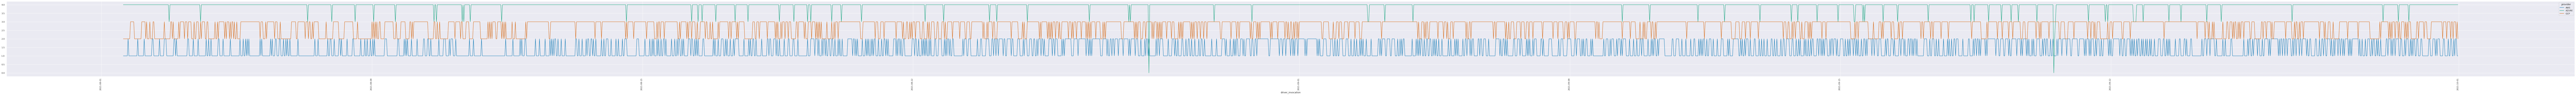

In [19]:
fig, ax = plt.subplots(figsize=(240,8))
dataset.groupby(['driver_invocation', 'provider'])['cpuType'].nunique().unstack().plot(ax=ax, kind='line')

plt.xticks(rotation=90)
utils.plot( ['data_analysis', f'cputypes'])

In [20]:
region = 'sa-east-1'
provider = 'AWS'

In [23]:
def get_average_responses_per_region_and_local_tod(dataset):
  df = dataset.groupby(['region', 'local_tod'], observed=True)[ ['driver_invocation'] ].agg(['count', 'nunique'])
  return (df[ ('driver_invocation', 'count') ] / df[ ('driver_invocation', 'nunique') ]).reset_index(name ='Average Responses')
avg_reponses_df = get_average_responses_per_region_and_local_tod(dataset)
avg_reponses_df = avg_reponses_df.set_index('local_tod')

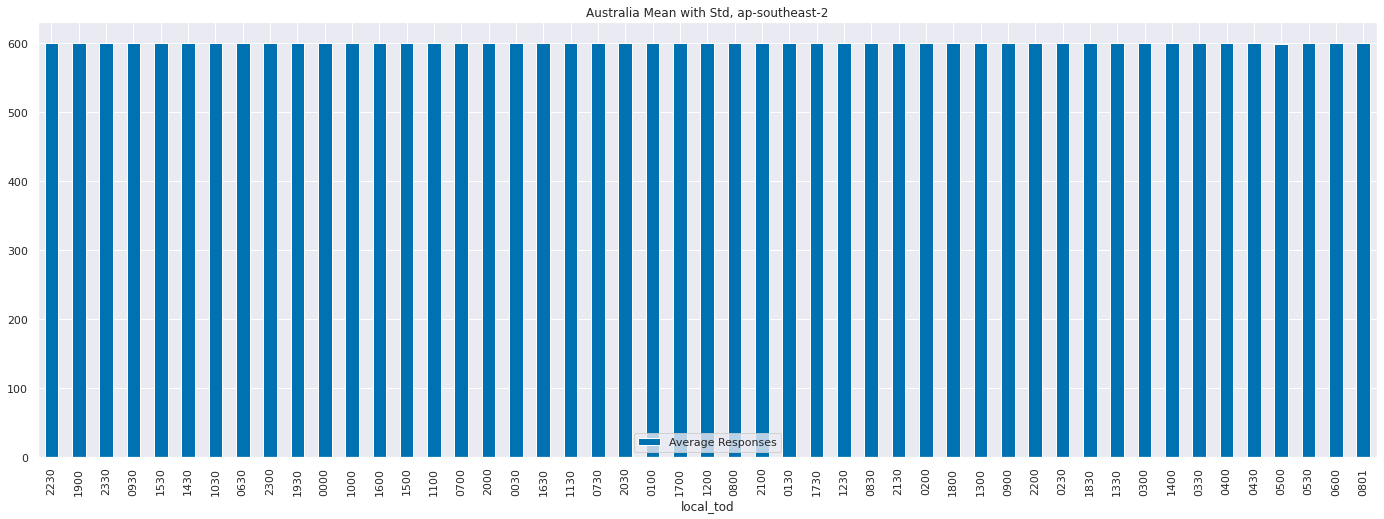

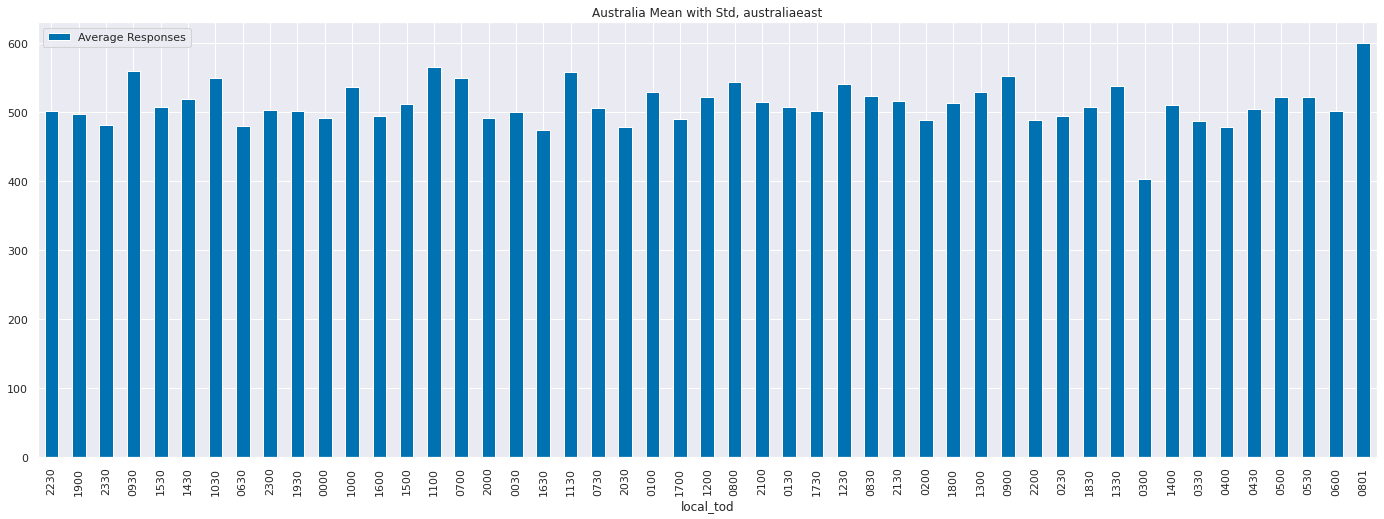

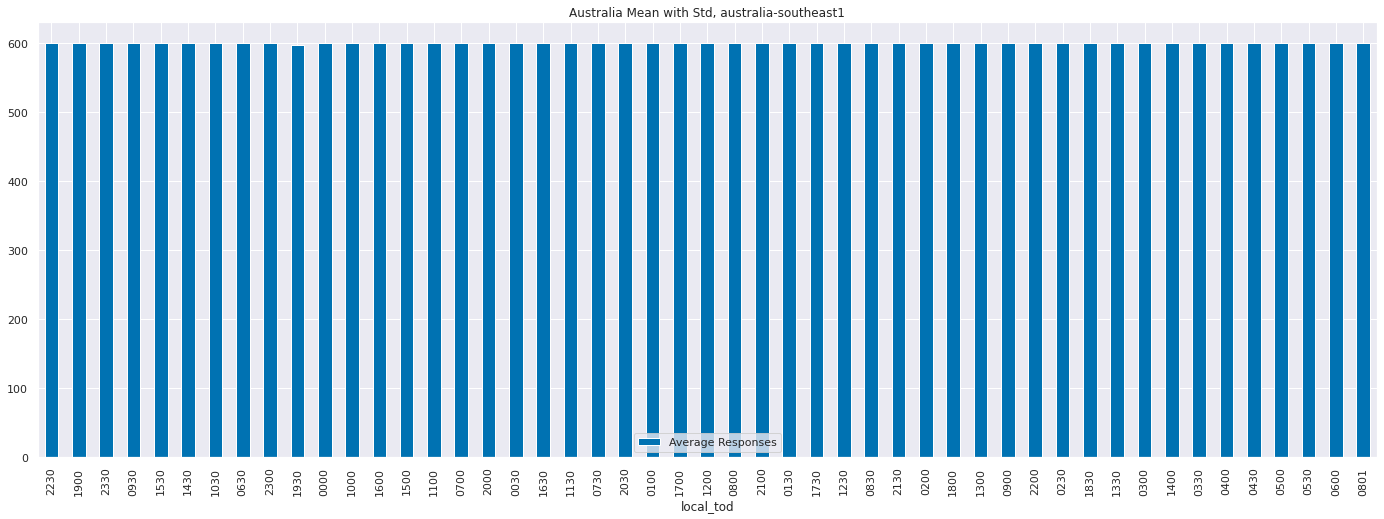

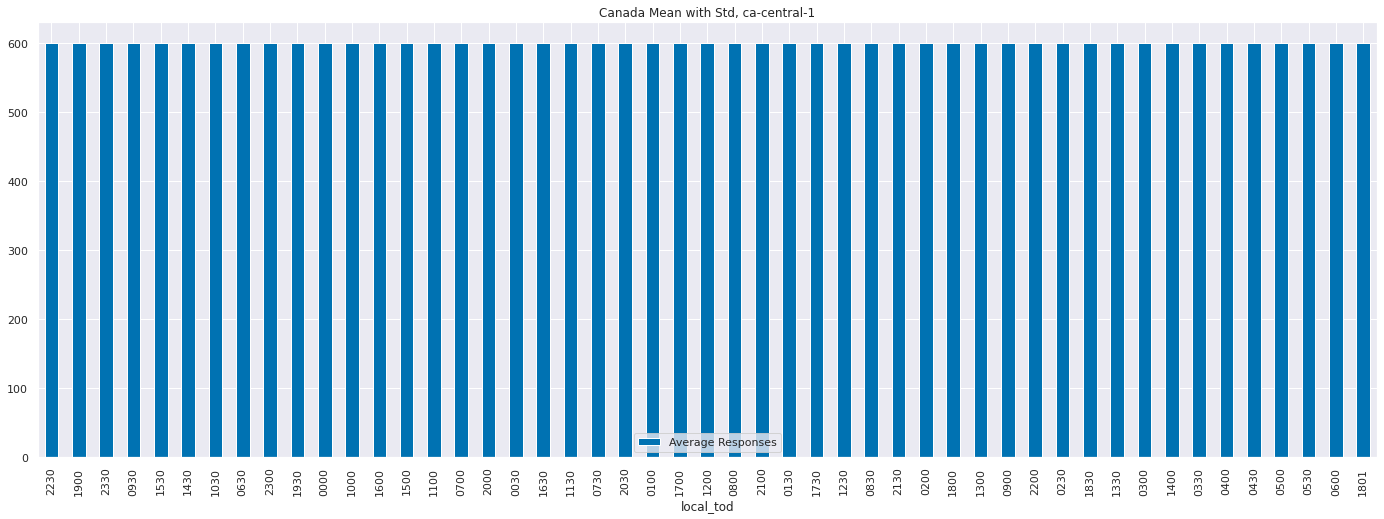

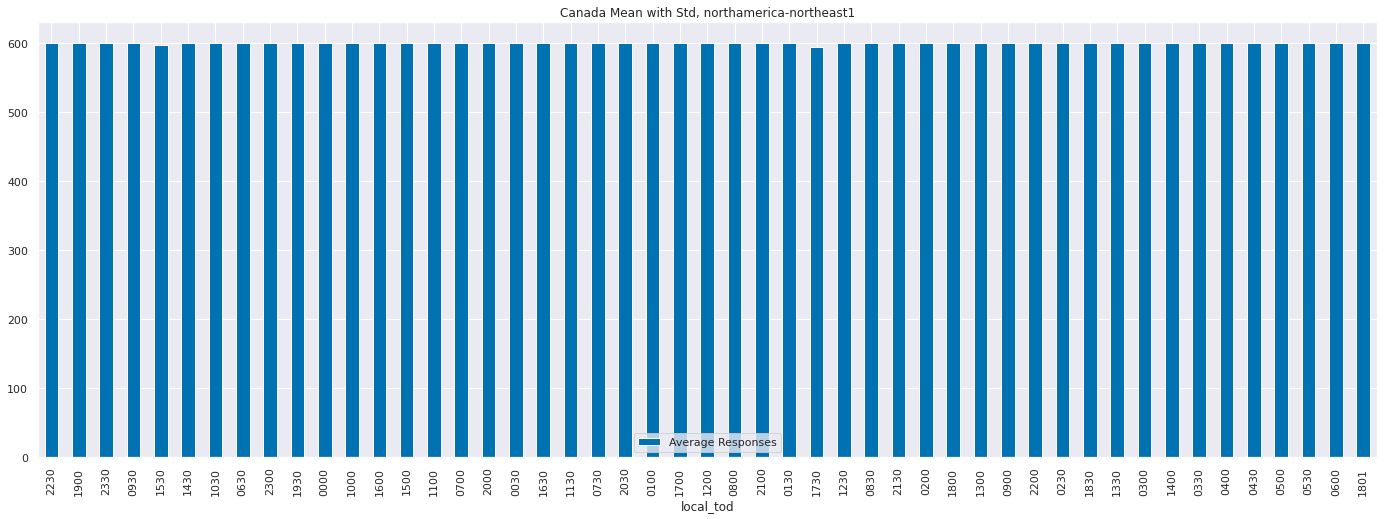

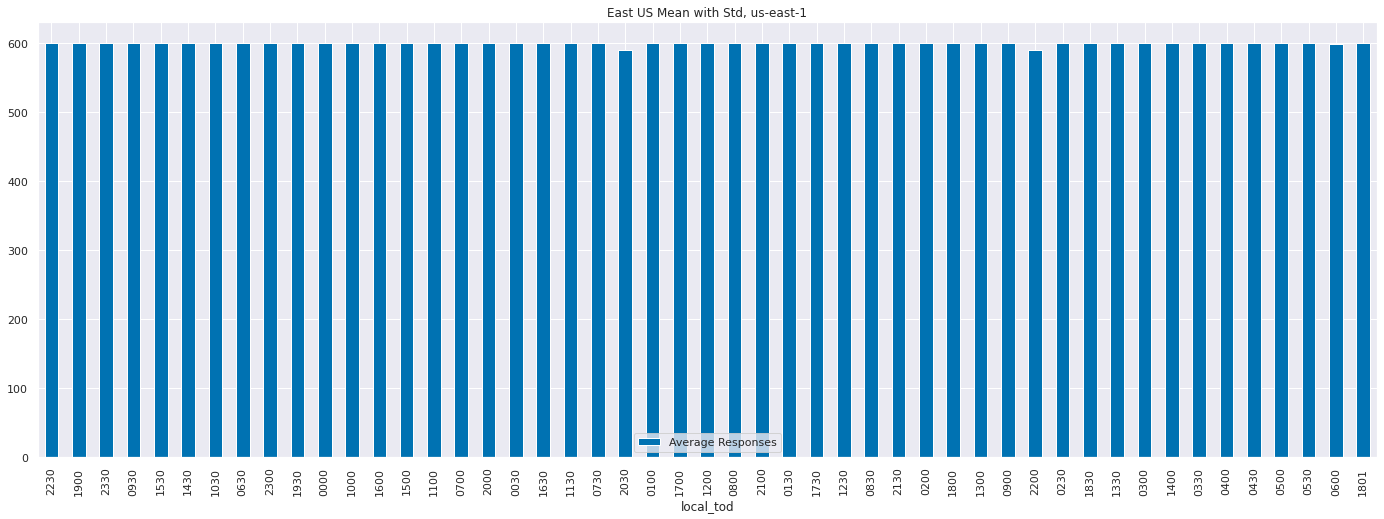

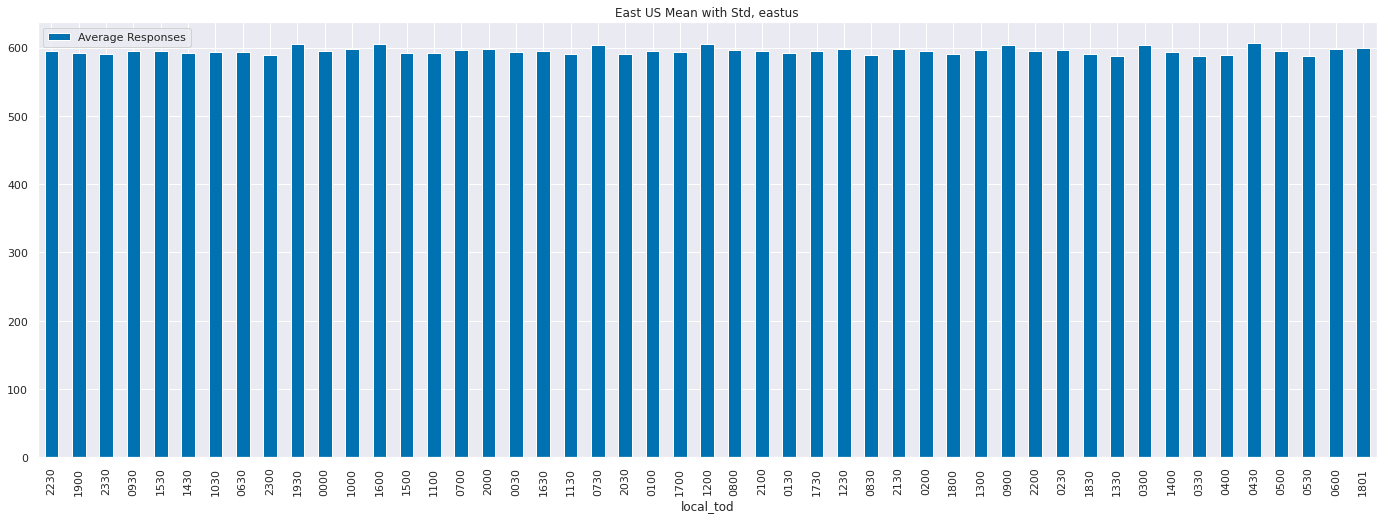

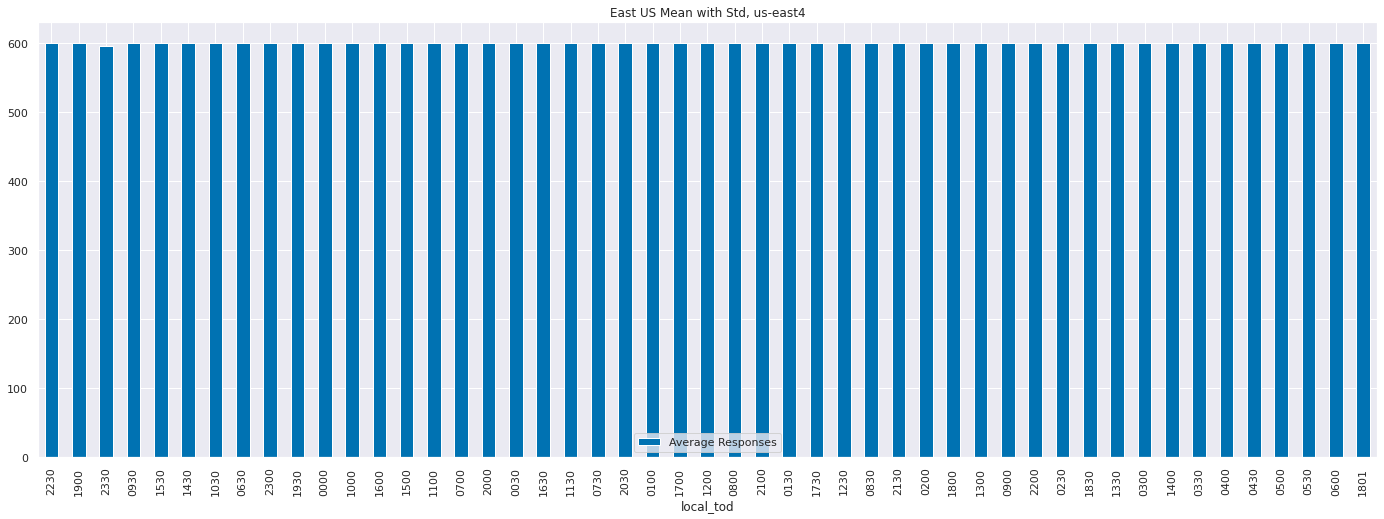

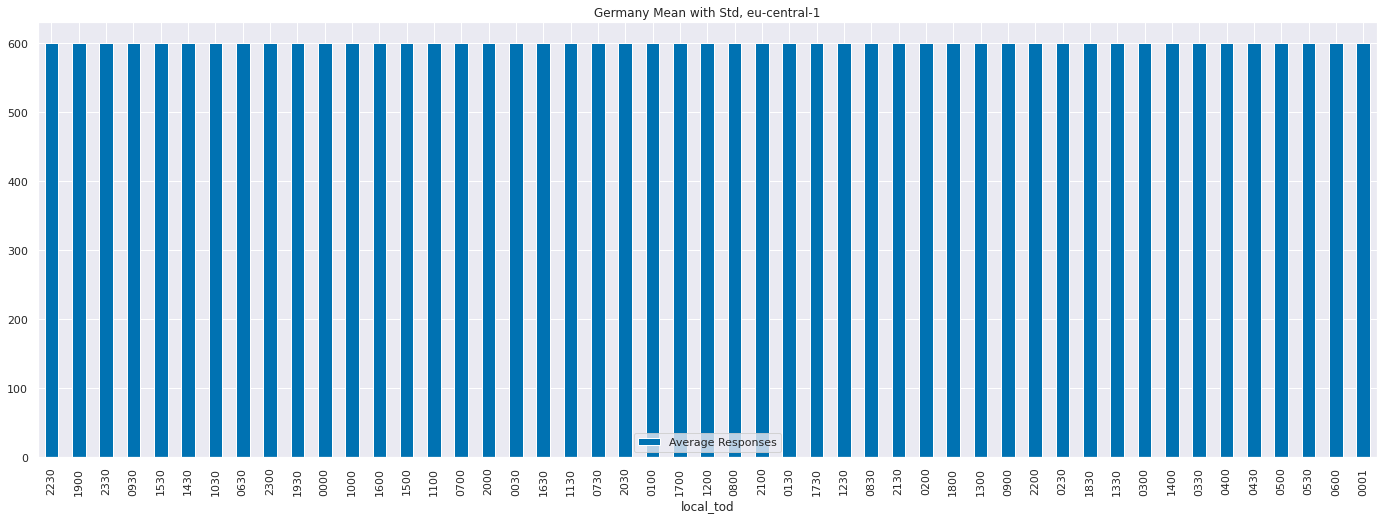

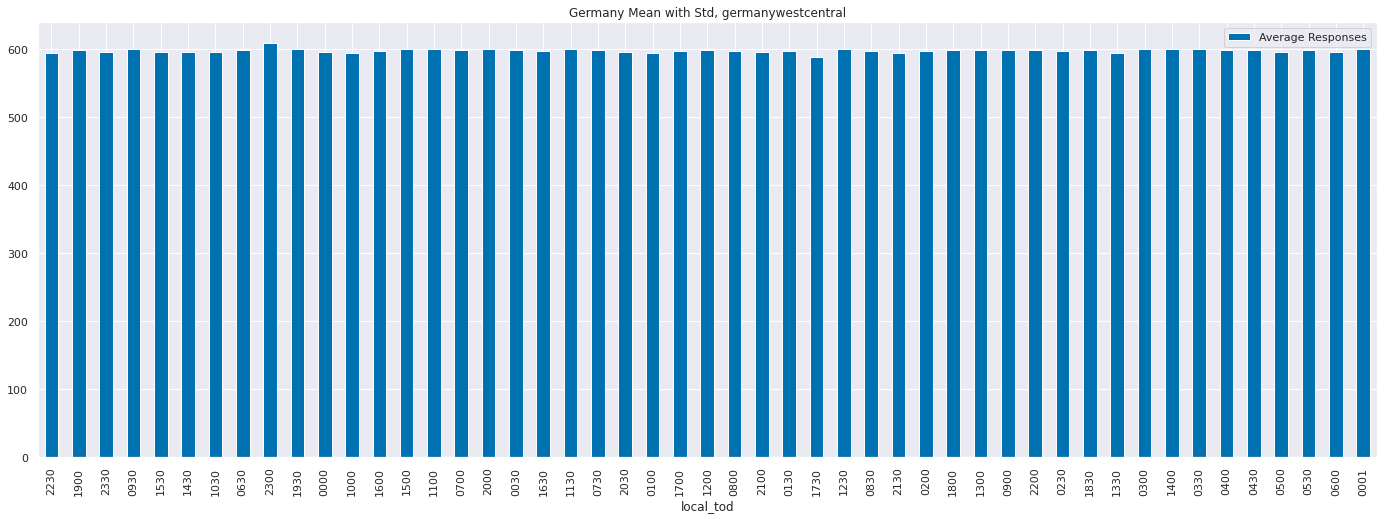

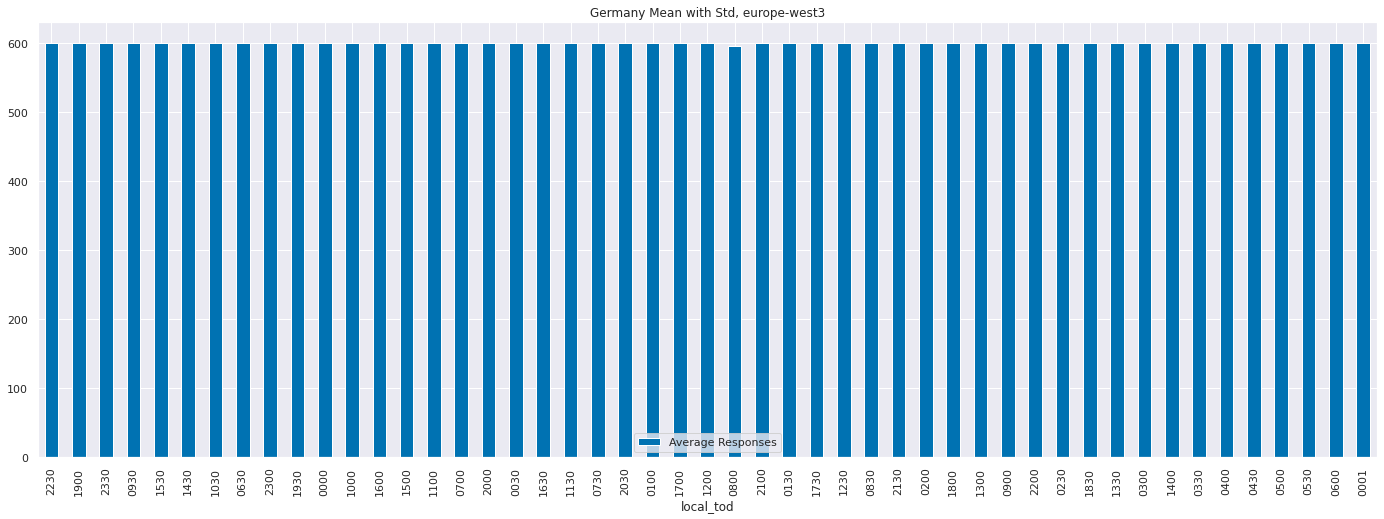

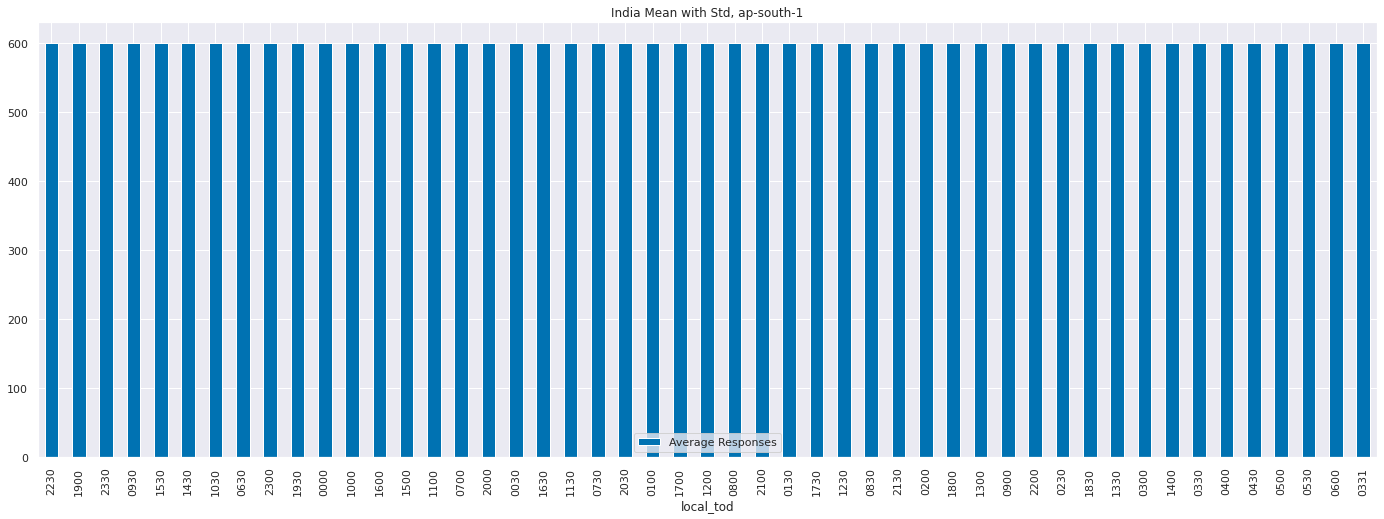

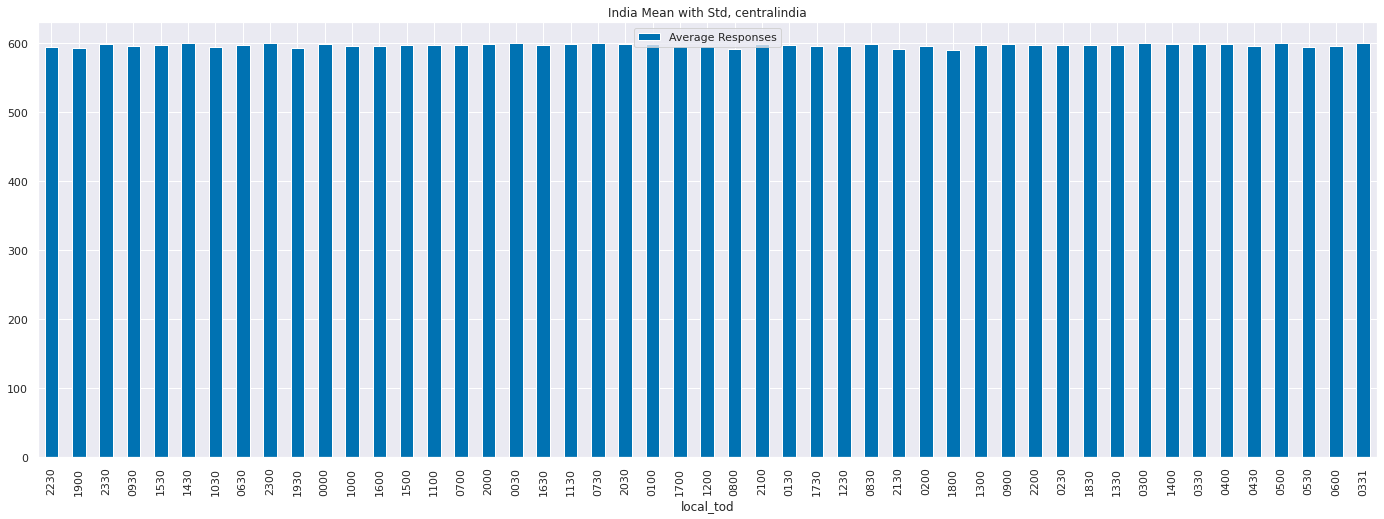

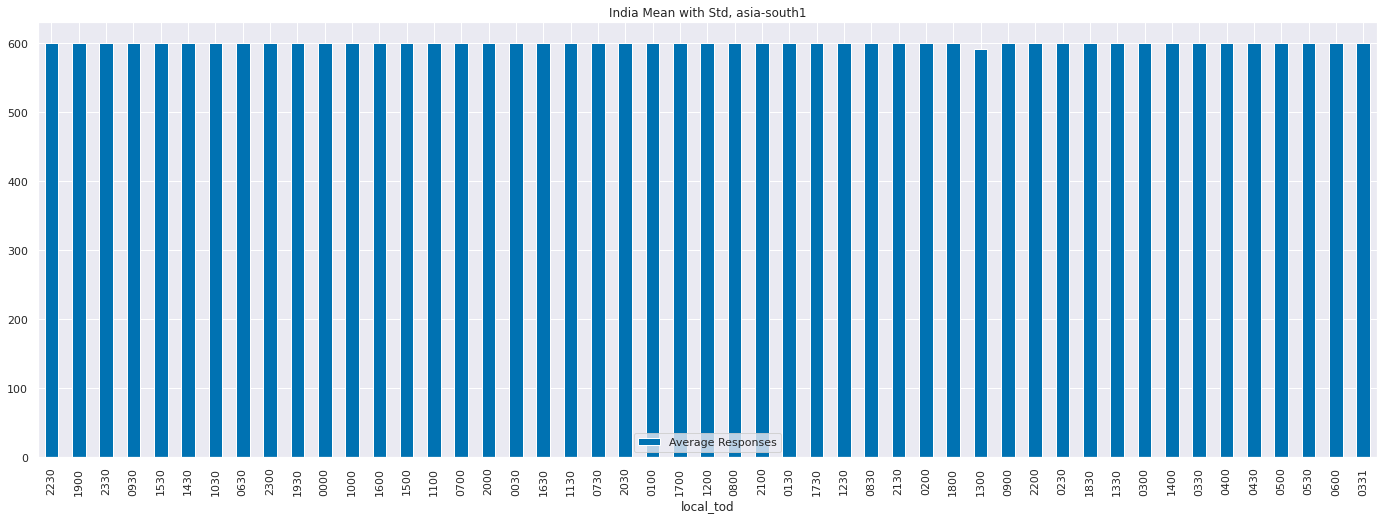

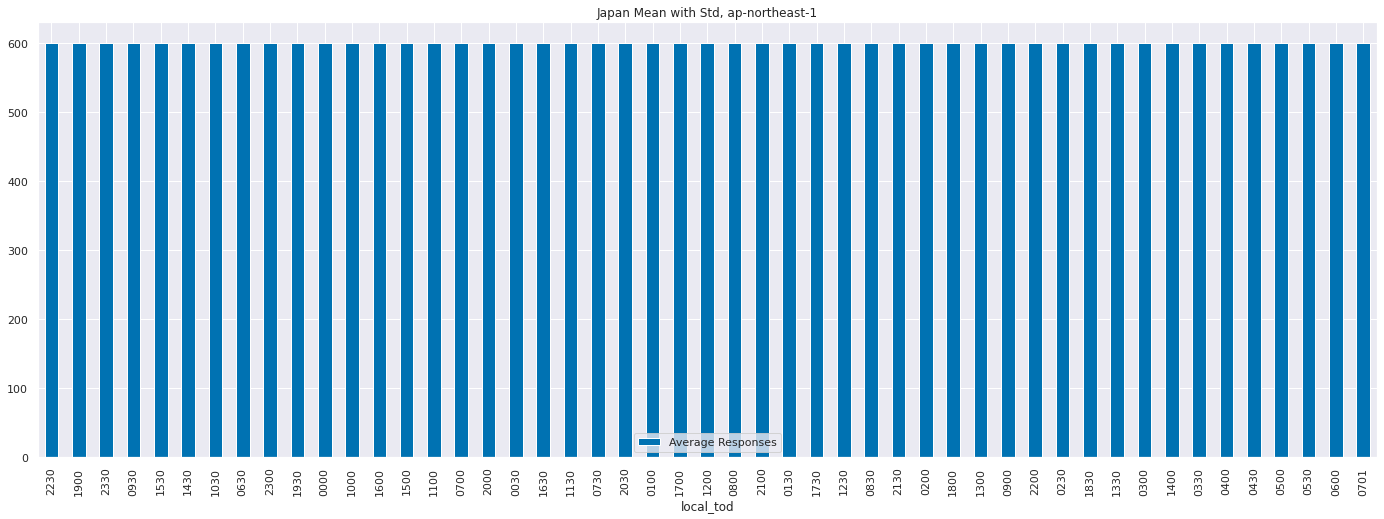

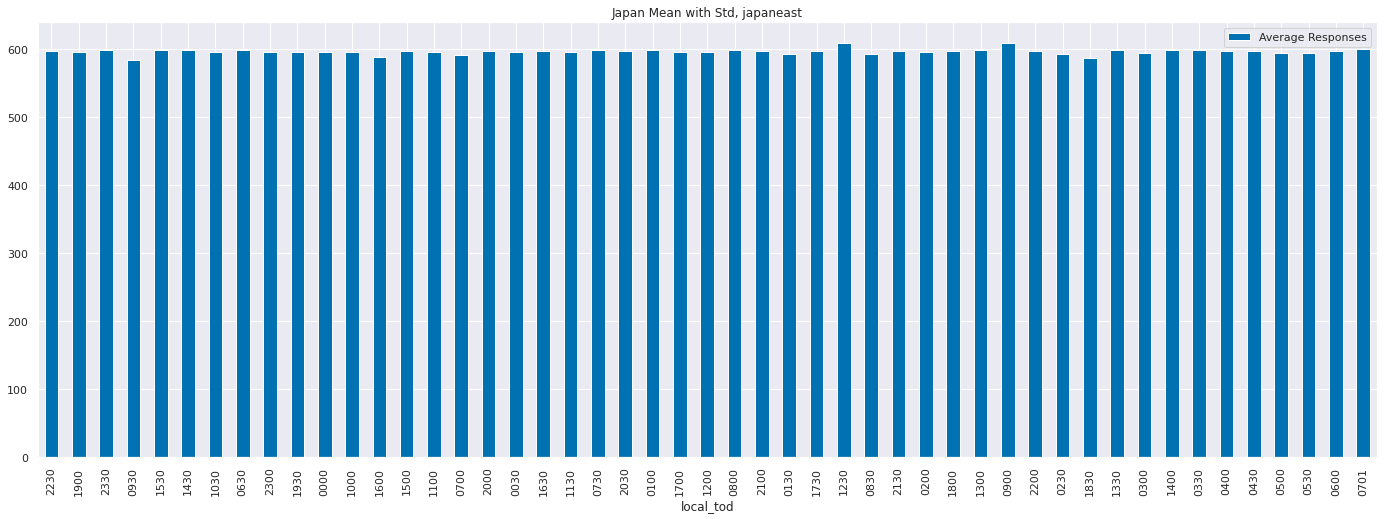

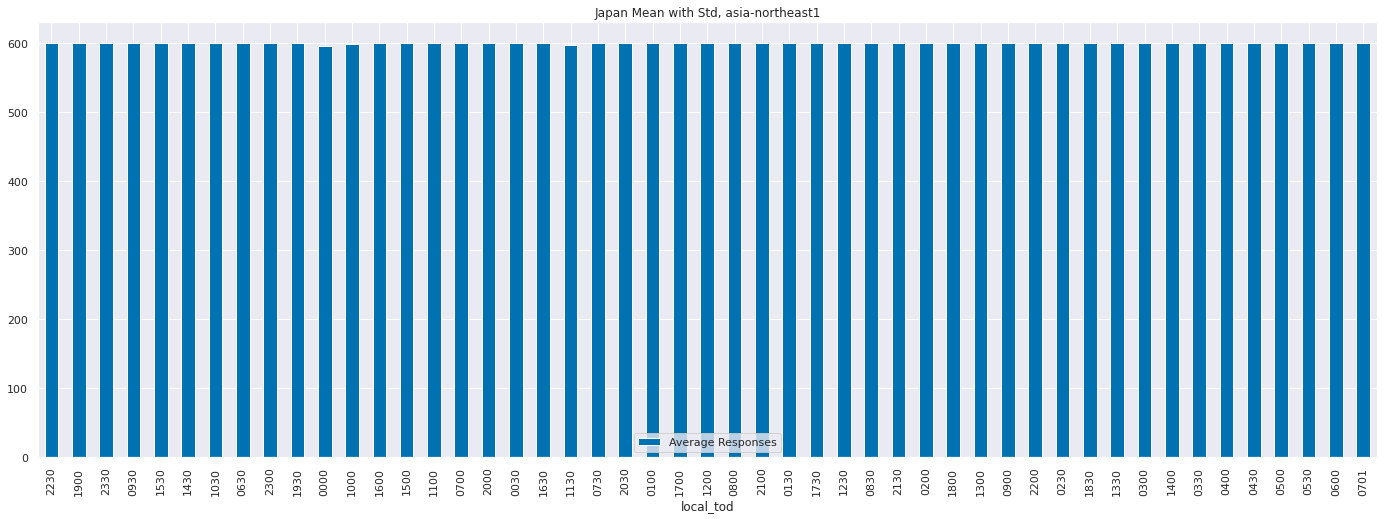

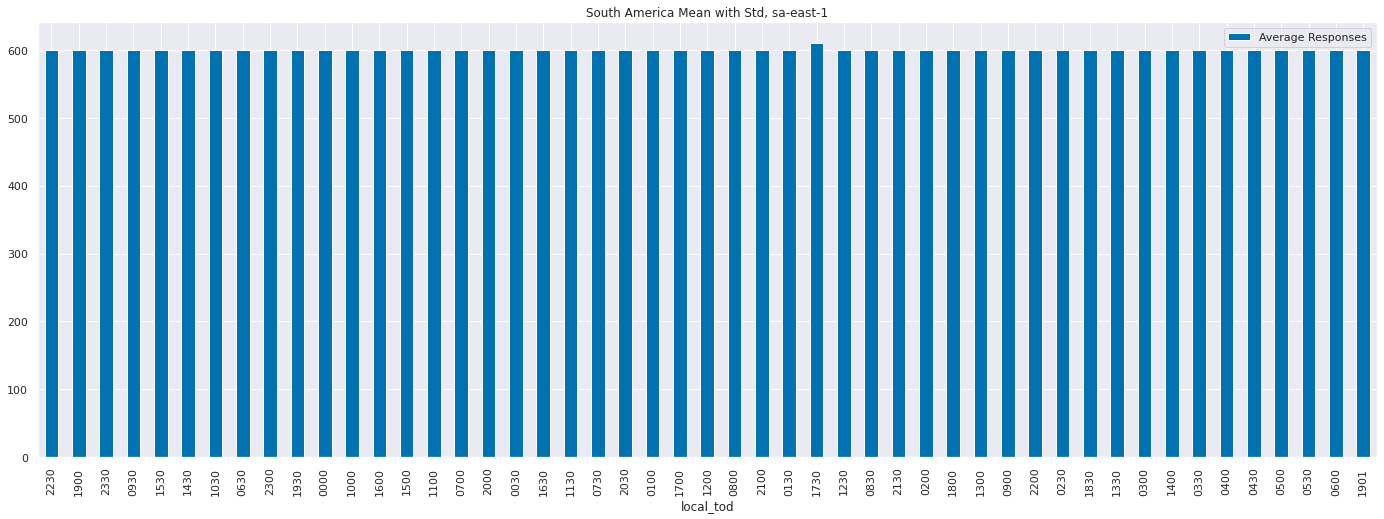

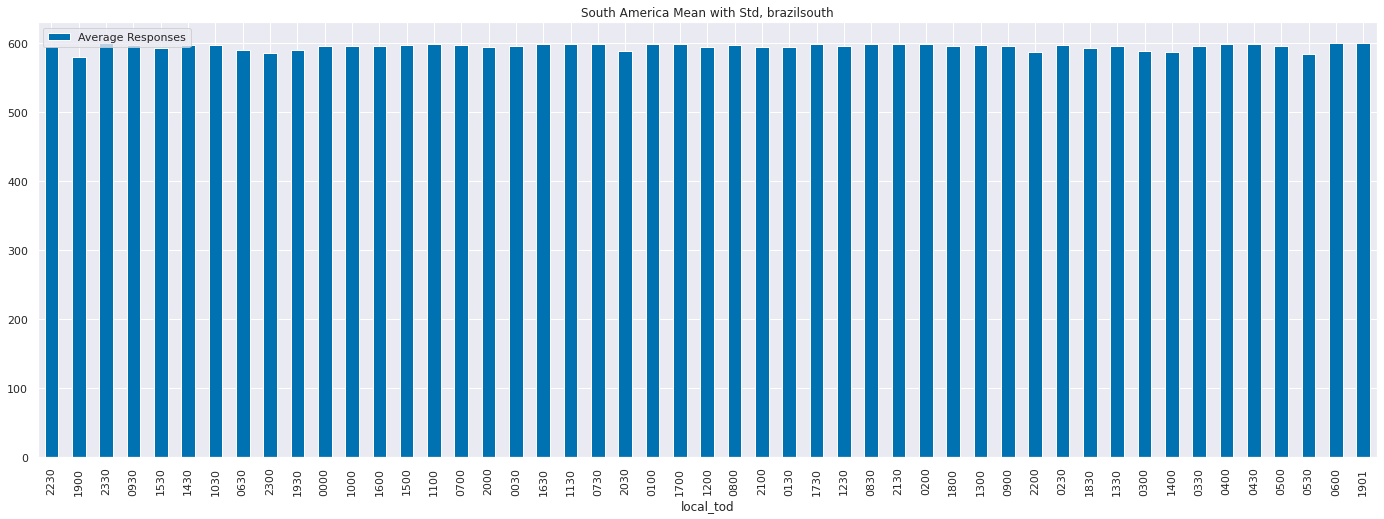

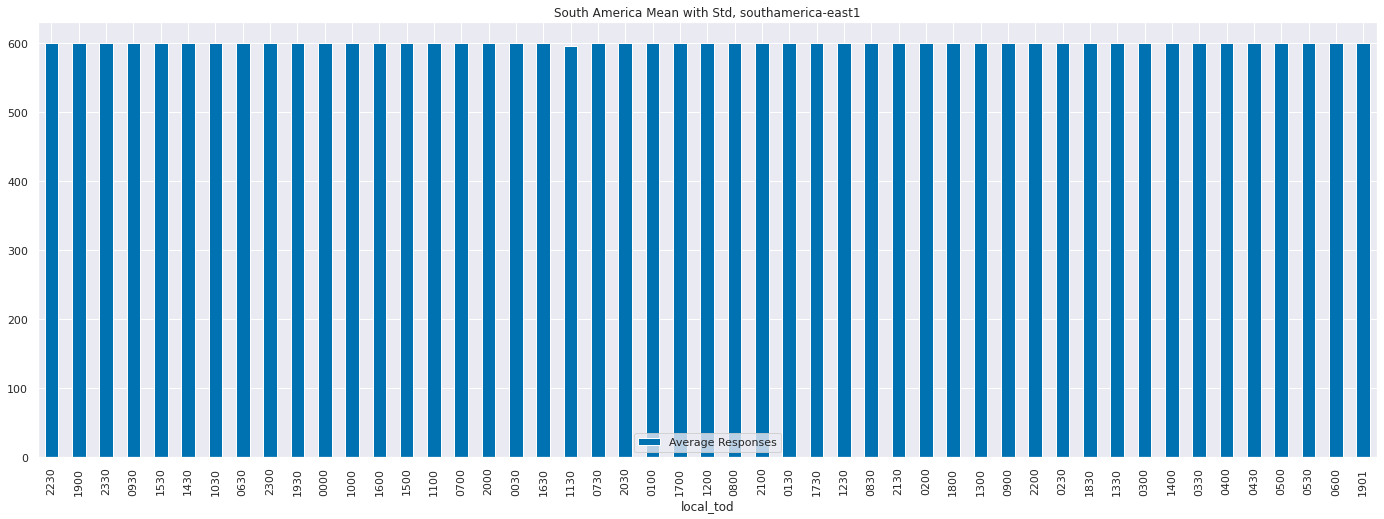

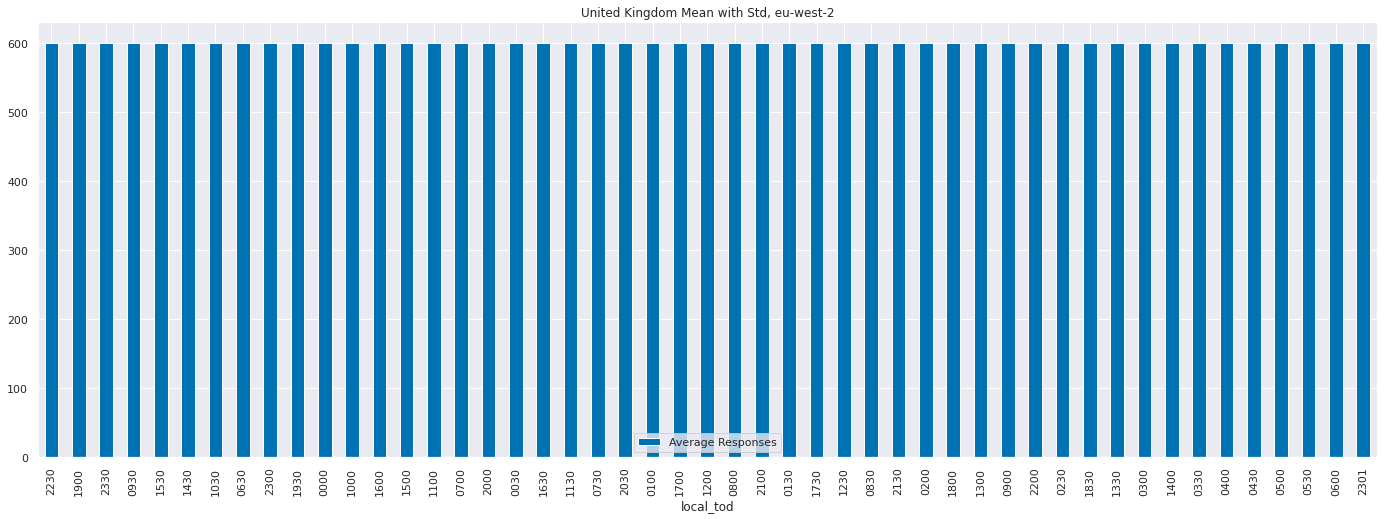

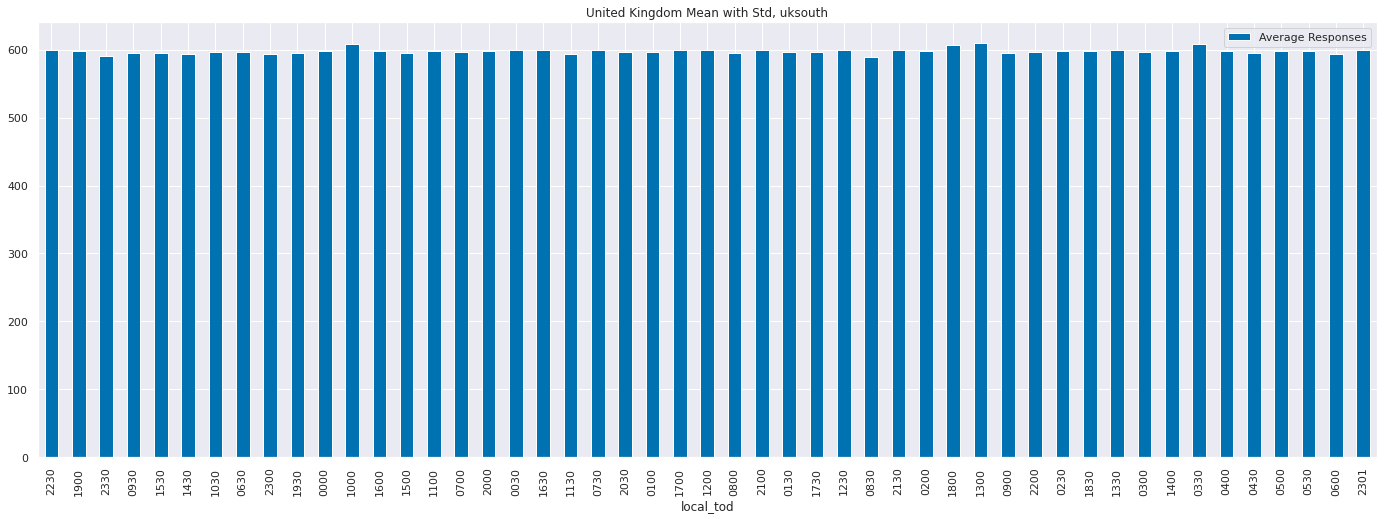

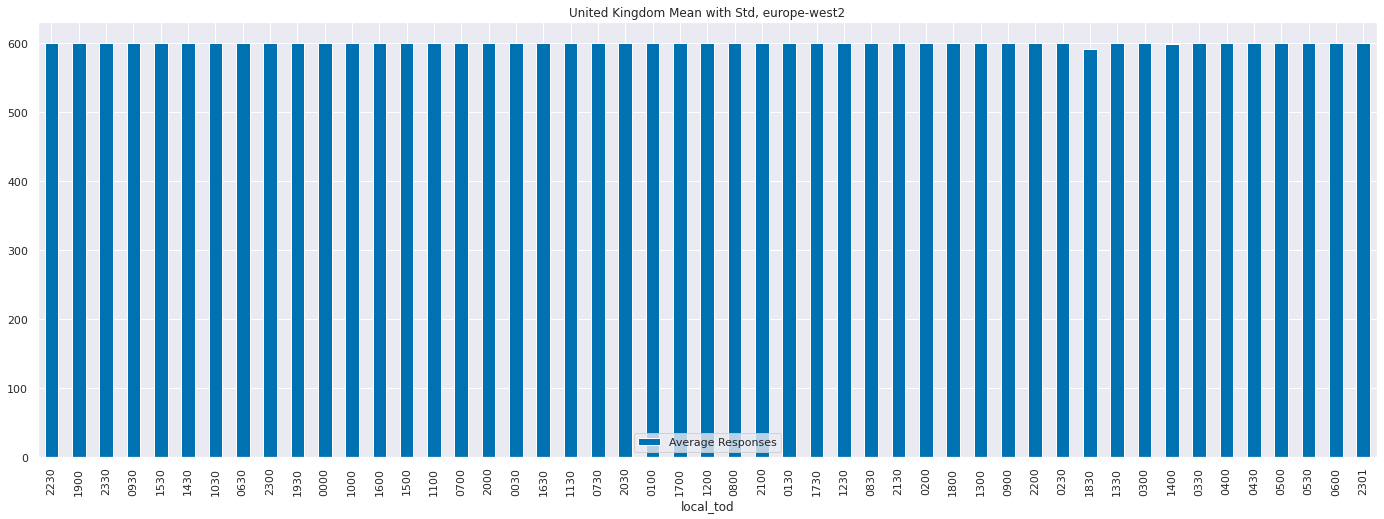

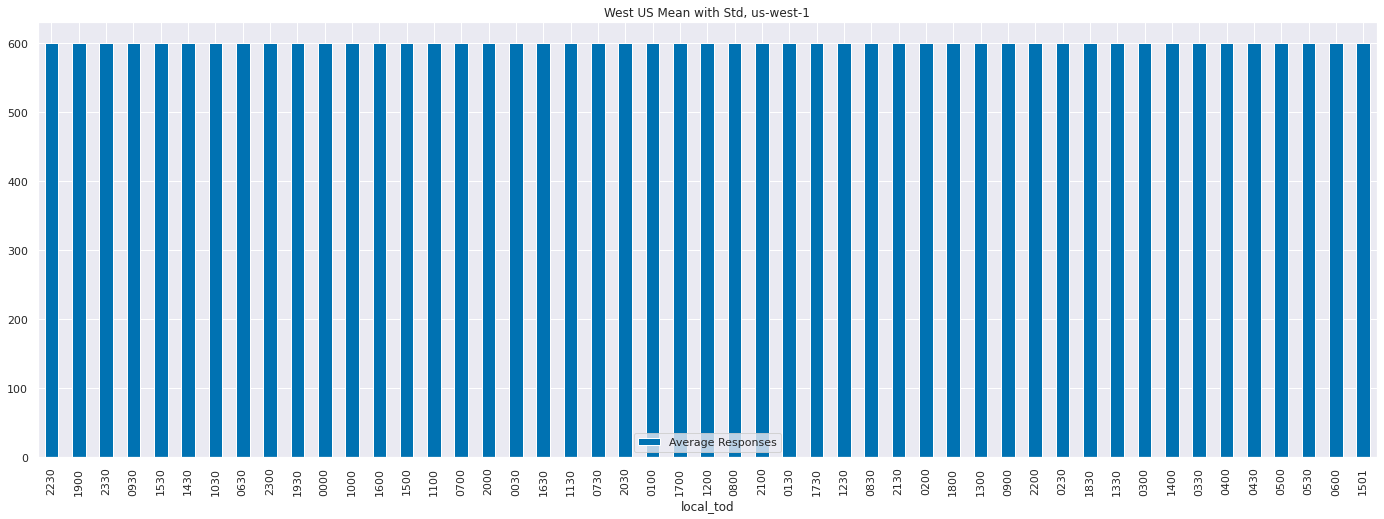

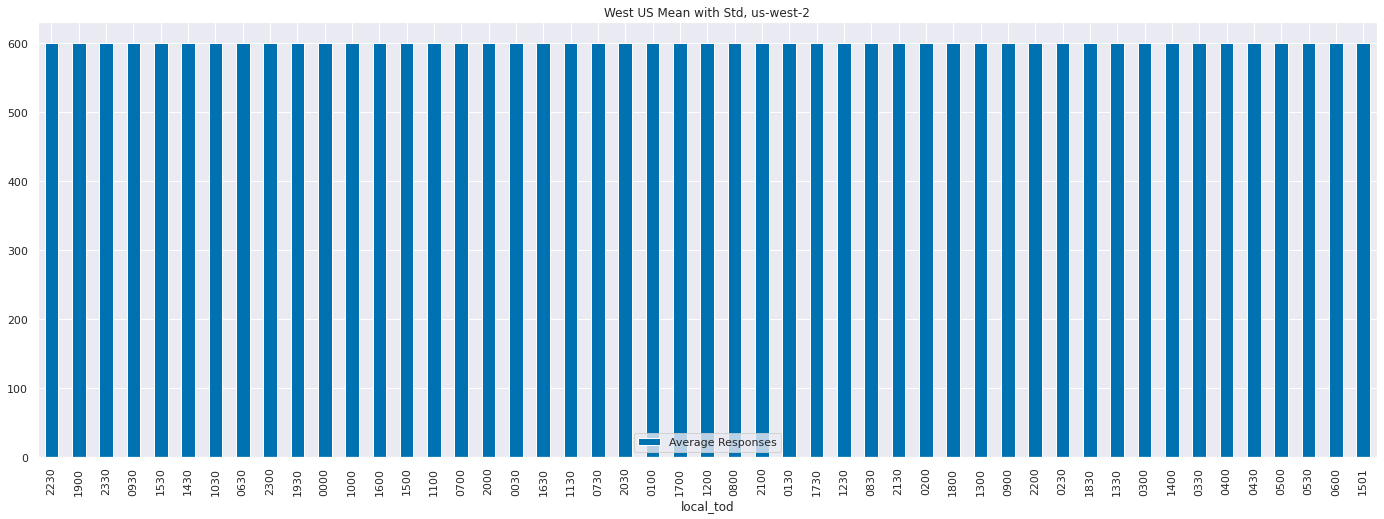

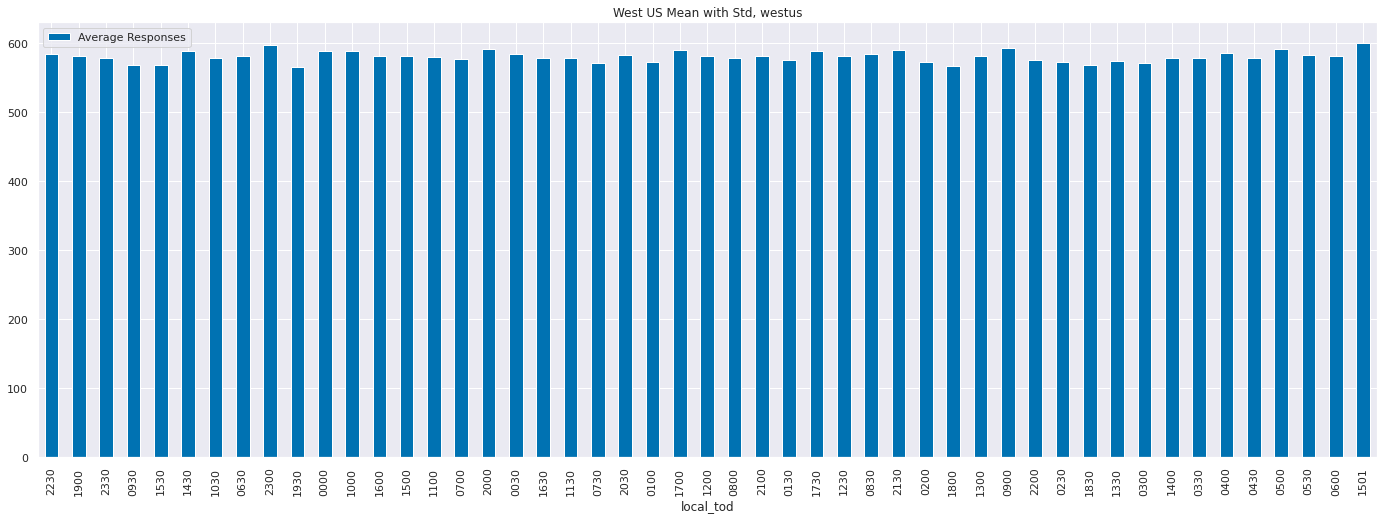

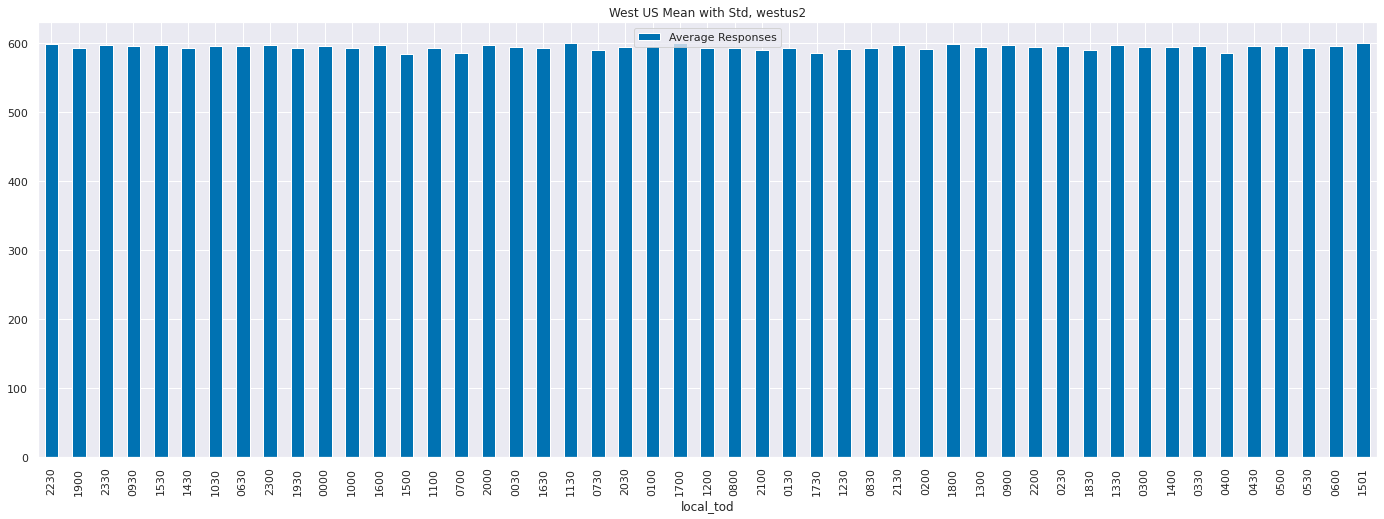

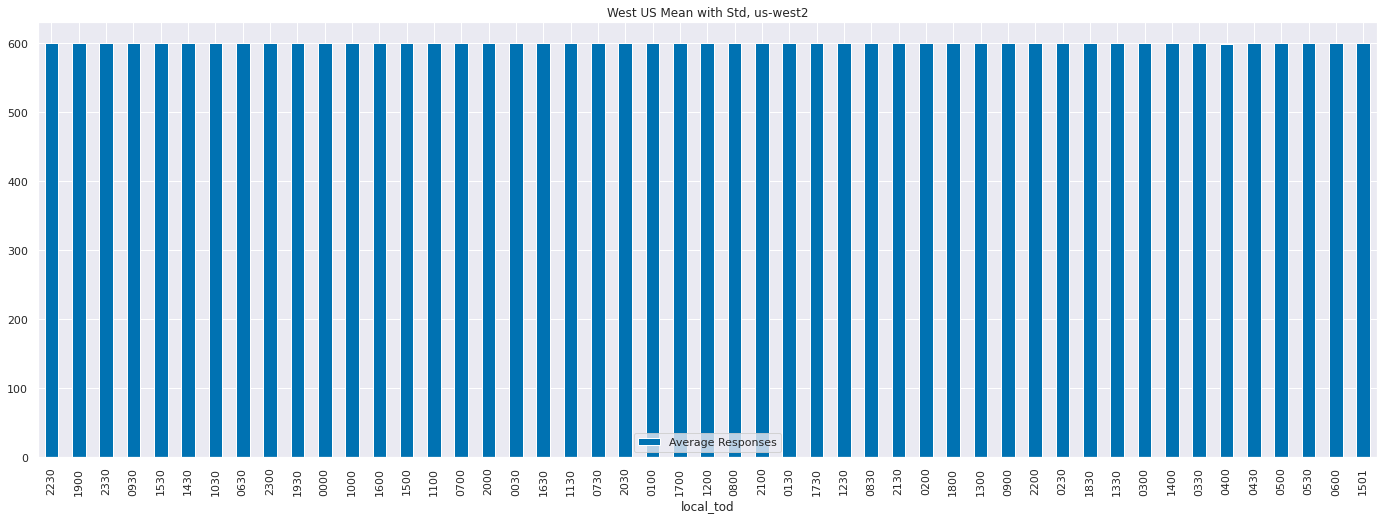

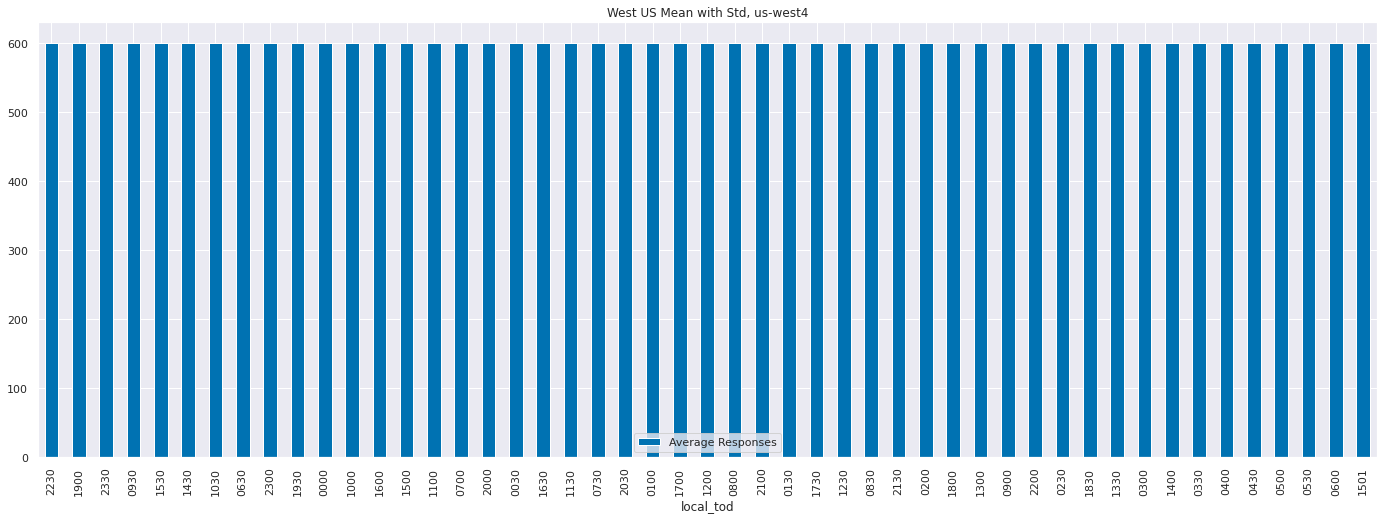

In [24]:
measure_group_region_df = dataset.groupby('measure group')['region'].unique()
for mg in measure_group_region_df.index:
    regions = measure_group_region_df.loc[mg]
    for region in regions:
        fig, ax = plt.subplots(figsize=(24,8))
        df = avg_reponses_df[avg_reponses_df['region'] == region]
        df.plot(title=f'{mg} Mean with Std, {region}', kind='bar',  ax=ax)
        utils.plot( ['data_analysis', f'mean_{region}'])